In [3]:
import json, re, random
from pathlib import Path
import pandas as pd

path = Path("C:/Users/DELL/Desktop/Projet-NLP/Formation_NLP_project_baseline-main/baseline_project - Copie/data/articles_classified.jsonl")
rows = [json.loads(l) for l in path.read_text(encoding="utf-8").splitlines() if l.strip()]

def clean_text(s: str) -> str:
    if not s:
        return ""
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

random.seed(42)
sample = random.sample(rows, k=min(200, len(rows)))

out = []
for i, r in enumerate(sample):
    title = clean_text(r.get("title", ""))
    content = clean_text(r.get("content", ""))

    # éviter "Title. Title"
    if content.lower().startswith(title.lower()):
        content = content[len(title):].strip(" .-")

    text = f"{title}. {content}".strip()[:1500]

    out.append({
        "id": i,
        "source": r.get("source", ""),
        "url": r.get("url", ""),
        "text": text,
        "label": "",  # à remplir à la main
        "baseline_pred": r.get("topic_prediction", "")  
    })

df = pd.DataFrame(out)
df.to_csv("../data/fine-tune_dataset.csv", index=False, encoding="utf-8")
print(" Saved: ../data/fine-tune_dataset.csv")
df[["id","source","baseline_pred","text"]].head()


 Saved: ../data/fine-tune_dataset.csv


,id,source,baseline_pred,text
0,0,HackerNews,Advanced,The Antarctic Snow Cruiser.
1,1,HackerNews,Intermediate,De-dollarization: Is the US dollar losing its ...
2,2,HackerNews,Advanced,Some C habits I employ for the modern day.
3,3,HackerNews,Advanced,Astrophotography visibility plotting and plann...
4,4,HackerNews,Advanced,jQuery 4.


In [8]:
import pandas as pd, re, textwrap, json, os, math, numpy as np

articles = [
{"title":"The 26,000-Year Astronomical Monument Hidden in Plain Sight","url":"https://longnow.org/ideas/the-26000-year-astronomical-monument-hidden-in-plain-sight/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Instabridge has acquired Nova Launcher","url":"https://novalauncher.com/nova-is-here-to-stay","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The Unix Pipe Card Game","url":"https://punkx.org/unix-pipe-game/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Show HN: Mastra 1.0, open-source JavaScript agent framework from the Gatsby devs","url":"https://github.com/mastra-ai/mastra","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Unconventional PostgreSQL Optimizations","url":"https://hakibenita.com/postgresql-unconventional-optimizations","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"I'm addicted to being useful","url":"https://www.seangoedecke.com/addicted-to-being-useful/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Show HN: wxpath – Declarative web crawling in XPath","url":"https://github.com/rodricios/wxpath","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Nvidia Stock Crash Prediction","url":"https://entropicthoughts.com/nvidia-stock-crash-prediction","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Linux kernel framework for PCIe device emulation, in userspace","url":"https://github.com/cakehonolulu/pciem","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"The Zen of Reticulum","url":"https://github.com/markqvist/Reticulum/blob/master/Zen%20of%20Reticulum.md","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"IP Addresses Through 2025","url":"https://www.potaroo.net/ispcol/2026-01/addr2025.html","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Level S4 solar radiation event","url":"https://www.swpc.noaa.gov/news/g4-severe-geomagnetic-storm-levels-reached-19-jan-2026","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"De-dollarization: Is the US dollar losing its dominance? (2025)","url":"https://www.jpmorgan.com/insights/global-research/currencies/de-dollarization","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Without benchmarking LLMs, you're likely overpaying 5-10x","url":"https://karllorey.com/posts/without-benchmarking-llms-youre-overpaying","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Apple testing new App Store design that blurs the line between ads and results","url":"https://9to5mac.com/2026/01/16/iphone-apple-app-store-search-results-ads-new-design/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Channel3 (YC S25) Is Hiring","url":"https://www.ycombinator.com/companies/channel3/jobs/3DIAYYY-backend-engineer","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Show HN: Ocrbase – pdf → .md/.json document OCR and structured extraction API","url":"https://github.com/majcheradam/ocrbase","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Reticulum, a secure and anonymous mesh networking stack","url":"https://github.com/markqvist/Reticulum","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"IP over Avian Carriers with Quality of Service (1999)","url":"https://www.rfc-editor.org/rfc/rfc2549.html","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The Alignment Game (2023)","url":"https://dmvaldman.github.io/alignment-game/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Running Claude Code dangerously (safely)","url":"https://blog.emilburzo.com/2026/01/running-claude-code-dangerously-safely/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Fast Concordance: Instant concordance on a corpus of >1,200 books","url":"https://iafisher.com/concordance/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"What came first: the CNAME or the A record?","url":"https://blog.cloudflare.com/cname-a-record-order-dns-standards/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The secret medieval tunnels that we still don't understand","url":"https://weirdmedievalguys.substack.com/p/the-secret-medieval-tunnels-that","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Increasing the performance of WebAssembly Text Format parser by 350%","url":"https://blog.gplane.win/posts/improve-wat-parser-perf.html","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The coming industrialisation of exploit generation with LLMs","url":"https://sean.heelan.io/2026/01/18/on-the-coming-industrialisation-of-exploit-generation-with-llms/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Prediction markets are ushering in a world in which news becomes about gambling","url":"https://www.theatlantic.com/technology/2026/01/america-polymarket-disaster/685662/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Nanolang: A tiny experimental language designed to be targeted by coding LLMs","url":"https://github.com/jordanhubbard/nanolang","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Benchmarking a Baseline Fully-in-Place Functional Language Compiler [pdf]","url":"https://trendsfp.github.io/papers/tfp26-paper-12.pdf","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Notes on Apple's Nano Texture (2025)","url":"https://jon.bo/posts/nano-texture/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Squishy Go","url":"https://puyogo.app/en/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"3D printing my laptop ergonomic setup","url":"https://www.ntietz.com/blog/3d-printing-my-laptop-ergonomic-setup/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Majority of CEOs report zero payoff from AI splurge","url":"https://www.theregister.com/2026/01/20/pwc_ai_ceo_survey/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Scaling long-running autonomous coding","url":"https://simonwillison.net/2026/Jan/19/scaling-long-running-autonomous-coding/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"OpenAI is rolling out age prediction","url":"https://openai.com/index/our-approach-to-age-prediction/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Targeted Bets: An alternative approach to the job hunt","url":"https://www.seanmuirhead.com/blog/targeted-bets","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"British redcoat's lost memoir reveals realities of life as a disabled veteran","url":"https://phys.org/news/2026-01-british-redcoat-lost-memoir-reveals.html","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"How Hightouch built their long-running agent harness","url":"https://www.amplifypartners.com/blog-posts/how-hightouch-built-their-long-running-agent-harness","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The microstructure of wealth transfer in prediction markets","url":"https://www.jbecker.dev/research/prediction-market-microstructure","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"x86 prefixes and escape opcodes flowchart","url":"https://soc.me/interfaces/x86-prefixes-and-escape-opcodes-flowchart.html","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"LLVM Adopts \"Human in the Loop\" Policy for AI/Tool-Assisted Contributions","url":"https://www.phoronix.com/news/LLVM-Human-In-The-Loop","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"I set all 376 Vim options and I'm still a fool","url":"https://evanhahn.com/i-set-all-376-vim-options-and-im-still-a-fool/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"From Nevada to Kansas by Glider","url":"https://www.weglide.org/flight/978820","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Google co-founder reveals that \"many\" of the new hires do not have a degree","url":"https://www.yahoo.com/news/articles/google-cofounder-reveals-tons-recent-231500103.html","source":"HackerNews","baseline_pred":"Beginner"},
{"title":"Giving university exams in the age of chatbots","url":"https://ploum.net/2026-01-19-exam-with-chatbots.html","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The assistant axis: situating and stabilizing the character of LLMs","url":"https://www.anthropic.com/research/assistant-axis","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Porsche sold more electrified cars in Europe in 2025 than pure gas-powered cars","url":"https://newsroom.porsche.com/en/2026/company/porsche-deliveries-2025-41516.html","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"San Francisco coyote swims to Alcatraz","url":"https://www.sfgate.com/local/article/san-francisco-coyote-alcatraz-21302218.php","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Nuudel: Non-Tracking Appointment Tool","url":"https://nuudel.digitalcourage.de/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Danish pension fund divesting US Treasuries","url":"https://www.reuters.com/business/danish-pension-fund-divest-its-us-treasuries-2026-01-20/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Kahan on the 8087 and designing Intel's floating point (2016) [video]","url":"https://www.youtube.com/watch?v=L-QVgbdt_qg","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The Overcomplexity of the Shadcn Radio Button","url":"https://paulmakeswebsites.com/writing/shadcn-radio-button/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Show HN: Artificial Ivy in the Browser","url":"https://da.nmcardle.com/grow","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Flux 2 Klein pure C inference","url":"https://github.com/antirez/flux2.c","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Understanding ZFS Scrubs and Data Integrity","url":"https://klarasystems.com/articles/understanding-zfs-scrubs-and-data-integrity/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Nova Launcher added Facebook and Google Ads tracking","url":"https://lemdro.id/post/lemdro.id/35049920","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The Antarctic Snow Cruiser","url":"https://www.amusingplanet.com/2026/01/the-antarctic-snow-cruiser.html","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Pale Moon v34.0.0 – a new milestone release","url":"https://www.palemoon.org/releasenotes.shtml","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Sending Data over Offline Finding Networks","url":"https://cc-sw.com/find-my-and-find-hub-network-research/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"The Old World Order Is Dead","url":"https://musgrave.substack.com/p/the-old-world-order-is-dead","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Show HN: An interactive physics simulator with 1000’s of balls, in your terminal","url":"https://github.com/minimaxir/ballin","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"How we made Python's packaging library 3x faster","url":"https://iscinumpy.dev/post/packaging-faster/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Conditions in the Intel 8087 floating-point chip's microcode","url":"https://www.righto.com/2025/12/8087-microcode-conditions.html","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"CSS Web Components for marketing sites (2024)","url":"https://hawkticehurst.com/2024/11/css-web-components-for-marketing-sites/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Tech workers ask their bosses to pressure Trump over ICE crackdowns","url":"https://www.washingtonpost.com/technology/2026/01/20/tech-ice-letter-protest/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Face as a QR Code","url":"https://bookofjoe2.blogspot.com/2025/12/your-face-as-qr-code.html","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Show HN: Subth.ink – write something and see how many others wrote the same","url":"https://subth.ink/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"ASCII characters are not pixels: a deep dive into ASCII rendering","url":"https://alexharri.com/blog/ascii-rendering","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Bypassing Gemma and Qwen safety with raw strings","url":"https://teendifferent.substack.com/p/apply_chat_template-is-the-safety","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"It's Sundowning in America","url":"https://paulkrugman.substack.com/p/its-sundowning-in-america","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Radboud University selects Fairphone as standard smartphone for employees","url":"https://www.ru.nl/en/staff/news/radboud-university-selects-fairphone-as-standard-smartphone-for-employees","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Show HN: Pipenet – A Modern Alternative to Localtunnel","url":"https://pipenet.dev/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Iterative image reconstruction using random cubic bézier strokes","url":"https://tangled.org/luthenwald.tngl.sh/splined","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Selling SaaS in Japan","url":"https://embedworkflow.com/blog/what-saas-founders-should-know-about-entering-the-japanese-market/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Use Social Media Mindfully","url":"https://danielleheberling.xyz/blog/mindful-social-media/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Nepal's Mountainside Teahouses Elevate the Experience for Trekkers","url":"https://www.smithsonianmag.com/travel/nepal-mountainside-teahouses-elevate-experience-trekkers-heading-to-top-world-180987844/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Nearly a third of social media research has undisclosed ties to industry","url":"https://www.science.org/content/article/nearly-third-social-media-research-has-undisclosed-ties-industry-preprint-claims","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Show HN: E80: an 8-bit CPU in structural VHDL","url":"https://github.com/Stokpan/E80","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Weight Transfer for RL Post-Training in under 2 seconds","url":"https://research.perplexity.ai/articles/weight-transfer-for-rl-post-training-in-under-2-seconds","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Graphics In Flatland – 2D ray tracing [video]","url":"https://www.youtube.com/watch?v=WYTOykSqf2Y","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"The Startup Graveyard","url":"https://www.loot-drop.io/","source":"HackerNews","baseline_pred":"Beginner"},
{"title":"Much of the World Facing 'Water Bankruptcy,' U.N. Report Warns","url":"https://e360.yale.edu/digest/water-bankruptcy-report","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Meta's legal team abandoned its ethical duties","url":"https://www.afterbabel.com/p/how-metas-lawyers-perfected-the-playbook","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Legal Structures for Latin American Startups (2021)","url":"https://latamlist.com/legal-structures-for-latin-american-startups/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Fix your robots.txt or your site disappears from Google","url":"https://www.alanwsmith.com/en/37/wa/jz/s1/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"MTOTP: Wouldn't it be nice if you were the 2FA device?","url":"https://github.com/VBranimir/mTOTP/tree/develop","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Dead Internet Theory","url":"https://kudmitry.com/articles/dead-internet-theory/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"F-16 Falcon Strike","url":"https://webchrono.pl/F16FalconStrike/index.html","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Opening the AWS European Sovereign Cloud","url":"https://aws.amazon.com/blogs/aws/opening-the-aws-european-sovereign-cloud/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Kiss Launcher – fast launcher for Android","url":"https://kisslauncher.com/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Folding NASA Experience into an Origamist's Toolkit (2024)","url":"https://spinoff.nasa.gov/Folding_NASA_Experience_into_an_Origamist%E2%80%99s_Toolkit","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"King – man + woman is queen; but why? (2017)","url":"https://p.migdal.pl/blog/2017/01/king-man-woman-queen-why/","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Gaussian Splatting – A$AP Rocky \"Helicopter\" music video","url":"https://radiancefields.com/a-ap-rocky-releases-helicopter-music-video-featuring-gaussian-splatting","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Threads edges out X in daily mobile users, new data shows","url":"https://techcrunch.com/2026/01/18/threads-edges-out-x-in-daily-mobile-users-new-data-shows/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"A decentralized peer-to-peer messaging application that operates over Bluetooth","url":"https://bitchat.free/","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"GLM-4.7-Flash","url":"https://huggingface.co/zai-org/GLM-4.7-Flash","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Understanding C++ Ownership System","url":"https://blog.aiono.dev/posts/understanding-c++-ownership-system.html","source":"HackerNews","baseline_pred":"Advanced"},
{"title":"Simple Sabotage Field Manual (1944) [pdf]","url":"https://www.cia.gov/static/5c875f3ec660e092cf893f60b4a288df/SimpleSabotage.pdf","source":"HackerNews","baseline_pred":"Intermediate"},
{"title":"Show HN: Munimet.ro – ML-based status page for the local subways in SF","url":"https://munimet.ro/","source":"HackerNews","baseline_pred":"Intermediate"},
]

# My own labels (heuristic / judgement based on title/topic depth)
def my_label(title: str) -> str:
    t = title.lower()
    # Advanced: deep systems/compilers/security/low-level/DB internals/LLM infra
    advanced_kw = [
        "postgresql", "pcie", "kernel", "microcode", "compiler", "benchmarking",
        "webassembly", "wat", "x86", "dns", "cname", "a record", "zfs", "scrubs",
        "mesh networking", "reticulum", "framework", "agent", "llm", "exploit",
        "packaging library", "llvm", "vhdl", "2d ray tracing", "gaussian splatting",
        "sovereign cloud", "aws", "2fa", "totp"
    ]
    # Beginner: fun/light/general-interest
    beginner_kw = ["startup graveyard", "coyote", "squishy", "card game", "origamist"]
    if any(k in t for k in beginner_kw):
        return "Beginner"
    if any(k in t for k in advanced_kw):
        return "Advanced"
    # Intermediate: most other tech/news/science explainers
    return "Intermediate"

df = pd.DataFrame([
    {
        "id": i,
        "source": a["source"],
        "url": a["url"],
        "text": a["title"],          # you only gave titles; put title as text
        "label": my_label(a["title"]),
        "baseline_pred": a["baseline_pred"],
        "title": a["title"],
    }
    for i, a in enumerate(articles)
])

out_path = "../data/articles_labeled.csv"
df.to_csv(out_path, index=False, encoding="utf-8")
out_path



'../data/articles_labeled.csv'

In [16]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("../data/articles_labeled.csv")  # ton dataset annoté
df = df.dropna(subset=["text","label"])

# baseline_pred doit exister (sinon tu le génères via ton baseline)
y_true = df["label"].astype(str)
y_pred = df["baseline_pred"].astype(str)

print("Baseline Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=2))
print(confusion_matrix(y_true, y_pred))


Baseline Accuracy: 0.5252525252525253
              precision    recall  f1-score   support

    Advanced       0.29      0.58      0.39        24
    Beginner       0.50      0.20      0.29         5
Intermediate       0.76      0.53      0.62        70

    accuracy                           0.53        99
   macro avg       0.52      0.44      0.43        99
weighted avg       0.63      0.53      0.55        99

[[14  0 10]
 [ 2  1  2]
 [32  1 37]]


In [8]:
import pandas as pd

df = pd.read_csv("../data/articles_labeled.csv") 
df = df.dropna(subset=["text","label"])

print(df["label"].value_counts())
print(df["label"].value_counts(normalize=True).round(3))


label
Intermediate    70
Advanced        24
Beginner        15
Name: count, dtype: int64
label
Intermediate    0.642
Advanced        0.220
Beginner        0.138
Name: proportion, dtype: float64


In [24]:
!pip install datasets


In [21]:
!pip -q install transformers datasets accelerate scikit-learn


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.4 which is incompatible.


In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Train:", len(train_df), "Test:", len(test_df))
print("Train distribution:\n", train_df["label"].value_counts())
print("Test distribution:\n", test_df["label"].value_counts())


Train: 87 Test: 22
Train distribution:
 label
Intermediate    56
Advanced        19
Beginner        12
Name: count, dtype: int64
Test distribution:
 label
Intermediate    14
Advanced         5
Beginner         3
Name: count, dtype: int64


In [10]:
import numpy as np
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Encode labels
le = LabelEncoder()
train_df = train_df.copy()
test_df = test_df.copy()

train_df["label_id"] = le.fit_transform(train_df["label"])
test_df["label_id"] = le.transform(test_df["label"])

train_ds = Dataset.from_pandas(train_df[["text","label_id"]]).rename_column("label_id","labels")
test_ds  = Dataset.from_pandas(test_df[["text","label_id"]]).rename_column("label_id","labels")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])
test_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)

    return {"accuracy": acc, "precision_macro": p_macro, "recall_macro": r_macro, "f1_macro": f1_macro}

args = TrainingArguments(
    output_dir="./finetuned_distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=20
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Map:   0%|          | 0/87 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\DELL\AppData\Local\Temp\ipykernel_11876\3991742933.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
20,0.985100
40,0.868800


TrainOutput(global_step=44, training_loss=0.9169642925262451, metrics={'train_runtime': 303.693, 'train_samples_per_second': 1.146, 'train_steps_per_second': 0.145, 'total_flos': 23049738418176.0, 'train_loss': 0.9169642925262451, 'epoch': 4.0})

Fine-tuned Accuracy: 0.6363636363636364

Per-class metrics:

              precision    recall  f1-score   support

    Advanced       0.00      0.00      0.00         5
    Beginner       0.00      0.00      0.00         3
Intermediate       0.64      1.00      0.78        14

    accuracy                           0.64        22
   macro avg       0.21      0.33      0.26        22
weighted avg       0.40      0.64      0.49        22



c:\Users\DELL\Desktop\ml\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\Desktop\ml\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\DELL\Desktop\ml\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


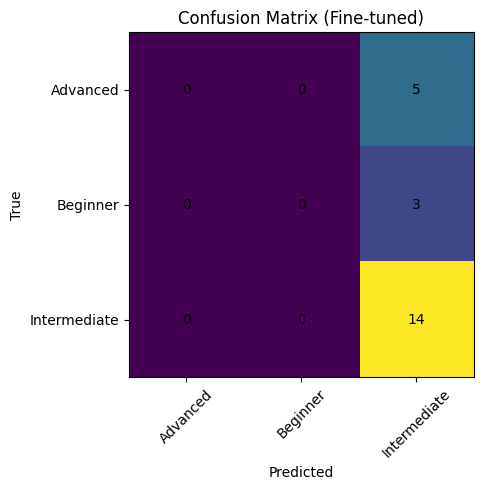

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

pred = trainer.predict(test_ds)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

print("Fine-tuned Accuracy:", accuracy_score(y_true, y_pred))
print("\nPer-class metrics:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=2))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix (Fine-tuned)")
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(range(len(le.classes_)), le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()
